In [1]:
!pip install -qq torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 torchtext==0.12.0
!pip install -qq speechbrain==0.5.12
!pip install -qq pyannote.audio

# for visualization purposes
#!pip install -qq moviepy ipython==7.34.0

In [2]:
!pip install pytube
import os


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pwd

/content


In [4]:

!pip install pytube
from pytube import YouTube
import os

yt = YouTube("https://www.youtube.com/watch?v=VBPTFlpv31k&list=PLrAXtmErZgOdP_8GztsuKi9nrraNbKKp4")
stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
stream.download('wav')

os.chdir('./wav')

def get_wav(videoname: str):
    os.rename(f'{videoname}', '1')
    com1 = f"ffmpeg -i 1 speech.mp3"
    com2 = f"ffmpeg -i speech.mp3 speech.wav"
    os.system(com1)
    os.system(com2)


get_wav("./Brian Armstrong Coinbase Cryptocurrency and Government Regulation  Lex Fridman Podcast 307.mp4")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from pyannote.audio import Pipeline
DEMO_FILE = '/content/wav/speech.wav'
pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization')
diarization = pipeline(DEMO_FILE)

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [6]:
import pandas as pd
cols = ['start', 'end', 'speaker']
l = []
for speech_turn, track, speaker in diarization.itertracks(yield_label=True):
    #print(f"{speech_turn.start:4.1f} {speech_turn.end:4.1f} {speaker}")
    l.append([speech_turn.start, speech_turn.end, track])
l[0]
df = pd.DataFrame(data= l,columns=cols)
df

,start,end,speaker
0,0.497812,16.596563,1
1,17.372812,47.494688,1
2,47.764688,58.007813,1
3,58.733438,66.192188,1
4,66.782813,98.997187,1
...,...,...,...
653,8868.833437,8891.564062,1
654,8892.239063,8909.063438,0
655,8909.350312,8933.059688,1
656,8933.279062,8936.519062,0


In [10]:
!pip install pydub
from pydub import AudioSegment
import math

class SplitWavAudioMubin():
    def __init__(self, folder, filename):
        self.folder = folder
        self.filename = filename
        self.filepath = filename
        
        self.audio = AudioSegment.from_wav(self.filepath)
    
    def export_files(self, df, DEMO_FILE):
        for i in range(df.shape[0]):
            t1 = round(df.loc[i, 'start'] * 1000, 2)
            t2 = round(df.loc[i, 'end'] * 1000, 2)
            
            newAudio = AudioSegment.from_wav(DEMO_FILE)
            newAudio = newAudio[t1:t2]
            newAudio.export('./' + f'Audio_{i}_file', format="wav")

    

folder = '.'
file = DEMO_FILE
split_wav = SplitWavAudioMubin(folder, file)
split_wav.export_files(df, DEMO_FILE)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import os

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_FILE = DEMO_FILE

1.11.0+cu102
0.11.0+cu102
cuda


In [13]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [14]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [15]:
def load_data_into_stt(bundle, audio_file):
    waveform, sample_rate = torchaudio.load(audio_file)
    waveform = waveform.to(device)

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    return waveform


In [16]:
def feature_extraction(waveform, model):
    with torch.inference_mode():
        features, _ = model.extract_features(waveform)
    return features


In [17]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Returns: str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [18]:
def stt(bundle, file):
    waveform = load_data_into_stt(bundle, file)
    features = feature_extraction(waveform, model)
    with torch.inference_mode():
        emission, _ = model(waveform)
    decoder = GreedyCTCDecoder(labels=bundle.get_labels())
    transcript = decoder(emission[0])
    return transcript

In [19]:
from os import listdir
from os.path import isfile, join



onlyfiles = [f for f in listdir('./') if isfile(join('./', f)) and "Audio" in f]
from tkinter import Tcl
onlyfiles = list(Tcl().call('lsort', '-dict', onlyfiles))

In [20]:
def adjust_df(df, bundle, Files):
    l = []
    for file in Files:
        try:
            txt = stt(bundle, file).replace('|', ' ').lower()
            l.append(txt)
        except RuntimeError:
            l.append('')
            pass
    df['text'] = l
    return df



new_df = adjust_df(df, bundle, onlyfiles)
new_df.head(15)

,start,end,speaker,text
0,0.497812,16.596563,1,ing is a conversation of brinarmstrong cofonde...
1,17.372812,47.494688,1,i recorded this conversation with brian before...
2,47.764688,58.007813,1,our world runs on money the exchange and store...
3,58.733438,66.192188,1,corn base and briane are trying to do this by ...
4,66.782813,98.997187,1,biracrisies resist change for better and for w...
5,99.317813,115.500938,1,this is thalex freadmen potgast te support it ...
6,115.079063,115.112813,0,
7,115.939688,168.252187,0,the first memory i have of programing was prob...
8,168.269063,193.244062,0,but it was so i felt like i was so confused ab...
9,193.328438,193.345313,0,


In [25]:
(new_df.text  == '').value_counts()

False    512
True     146
Name: text, dtype: int64

In [26]:
def lemmatizing(list):
    wnl = WordNetLemmatizer()
    lemmatized_list = []
    for words in list:
        lemmatized_list.append(wnl.lemmatize(words))
    return lemmatized_list


import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
 
lemmatizer = WordNetLemmatizer()

def applay_lemmatization2(df):
    new_df = []
    wnl = WordNetLemmatizer()
    for i in range(len(df)):
        pos_tagged = nltk.pos_tag(nltk.word_tokenize(df['text'][i]))
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
        lemmatized_sentence = []
        for word, tag in wordnet_tagged:
            if tag is None:
                lemmatized_sentence.append(word)
            else:       
                lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        new_df.append( " ".join(lemmatized_sentence))

    return new_df



def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None




[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [33]:
import nltk
nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
new_df['text'] = applay_lemmatization2(df)

In [36]:
new_df.head(-5)

,start,end,speaker,text
0,0.497812,16.596563,1,ing be a conversation of brinarmstrong cofonde...
1,17.372812,47.494688,1,i record this conversation with brian before t...
2,47.764688,58.007813,1,our world run on money the exchange and store ...
3,58.733438,66.192188,1,corn base and briane be try to do this by work...
4,66.782813,98.997187,1,biracrisies resist change for good and for bad...
...,...,...,...,...
648,8747.299687,8789.487187,0,that 's crazy and i have iad never start like ...
649,8789.740312,8794.937813,0,seven year a no it 's prbabym mike ten year of...
650,8795.528438,8798.616562,0,um qrenby 's have a valuation over a million d...
651,8798.768437,8813.567812,0,so it it be out of my realm of what be even po...


In [37]:
df = new_df

In [38]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 10.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=b083045c4507a8b58c8a8d4ab6ffd738c34b99b4250a9213b037d871fa9bdef5
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [39]:
import urllib.request
import random
import re
import string
from warnings import filterwarnings
filterwarnings('ignore')
import numpy as np
import pandas as pd

import nltk as nl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import gutenberg
from warnings import filterwarnings
filterwarnings('ignore')
nl.download('stopwords')
nl.download('wordnet')
nl.download('punkt')
nl.download('omw-1.4')
stop_words=set(stopwords.words("english"))

from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import gensim.corpora as corpora
import gensim
import pyLDAvis

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize, LabelEncoder
le = LabelEncoder()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7

In [40]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
def MLP(X , y):
    model_MLP = MLPClassifier(random_state=1, max_iter=10)
    model_MLP.fit(X , y)
    y_MLP = model_MLP.predict(X)
    print(accuracy_score(y, y_MLP))
    return model_MLP, y_MLP

In [41]:
from sklearn.cluster import KMeans
def K_means(X):
    model_km = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
    model_km.fit(X)
    y_km = model_km.fit_predict(X)
    return model_km, y_km

In [42]:
from sklearn.naive_bayes import GaussianNB
def NB(x , y ):
  gnb = GaussianNB()
  model_NB = gnb.fit(x, y)
  y_NB = model_NB.predict(x)
  print(accuracy_score(y, y_NB))
  return gnb, y_NB

In [93]:
from sklearn.svm import SVC
def SVM(x , y ):
  svm = SVC(gamma='auto' , kernel = 'linear')
  model_SVM = svm.fit(x, y)
  y_SVM = model_SVM.predict(x)
  print(accuracy_score(y, y_SVM))
  return model_SVM, y_SVM

In [44]:
from sklearn.cluster import AgglomerativeClustering
def Agglomorative(X):
    model_agg = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean',
                                        linkage = 'ward', compute_distances=True)
    y_agg_bow = model_agg.fit_predict(X)
    return model_agg, y_agg_bow

In [45]:
from sklearn.decomposition import TruncatedSVD
from copy import deepcopy

def dim_reduction(X, model, centers=0):
    svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    
    components = svd.fit_transform(X)
    components_df = pd.DataFrame(data = components,
                columns = ['bow component 1', 'bow component 2'])
    if type(centers) == type(0):
        centers = svd.transform(model.cluster_centers_)
    centers_new = deepcopy(centers)
    return centers_new, components_df, components

In [46]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import cohen_kappa_score

def Evaluate(y_actual, y_prediction):
    kappa = cohen_kappa_score(y_actual, y_prediction)
    sil = silhouette_score(y_actual, y_prediction)
    indices = ['kappa', 'silhouette']
    return pd.DataFrame(data=[kappa, sil], index=indices, columns=['values'])

In [98]:
import matplotlib.pyplot as plt
colors = ['b', 'y']
authors = ['a', 'b']

def visualizeClusters(components, y_train, centers):
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    
    ax.set_xlabel('1st Component', fontsize = 12)
    ax.set_ylabel('2nd Component', fontsize = 12)
    ax.set_title('Clusters visualization', fontsize = 18)
    
    for color, i, target_name in zip(colors, [0, 1], authors):
        ax.scatter(components[y_train.iloc[:, 0] == i, 0],
                   components[y_train.iloc[:, 0] == i, 1],
                   alpha=.8, color=color, label=target_name, s = 20)
        #print(y_train.iloc[:, 0] == i)
        
    ax.legend(loc='best', shadow=False, scatterpoints=1)
    #ax.scatter(centers[:,0], centers[:,1], marker='*', c='k',
               #label = 'centroid', s=350)

In [99]:
import scipy.cluster.hierarchy as sch
def visualizeHierarchy(X, y):
    plt.xlim(-15,15)
    plt.ylim(-15,15)

    dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

    plt.scatter(X[y ==0,0], X[y == 0,1], s=100, c='red')
    plt.scatter(X[y ==1,0], X[y == 1,1], s=100, c='yellow')
    # plt.scatter(X[y ==2,0], X[y == 2,1], s=100, c='blue')
    # plt.scatter(X[y ==3,0], X[y == 3,1], s=100, c='cyan')
    # plt.scatter(X[y ==4,0], X[y == 4,1], s=100, c='green')

In [100]:
df  = df.loc[df['text'] != '']
df

,start,end,speaker,text
0,0.497812,16.596563,1,ing be a conversation of brinarmstrong cofonde...
1,17.372812,47.494688,1,i record this conversation with brian before t...
2,47.764688,58.007813,1,our world run on money the exchange and store ...
3,58.733438,66.192188,1,corn base and briane be try to do this by work...
4,66.782813,98.997187,1,biracrisies resist change for good and for bad...
...,...,...,...,...
653,8868.833437,8891.564062,1,and the universe be a way of smile and na help...
654,8892.239063,8909.063438,0,yeah i mean i don im not eterally subscribe al...
655,8909.350312,8933.059688,1,sobuian thank you for drink big ah thank you f...
656,8933.279062,8936.519062,0,thanks for your assum podcast i i love it i li...


In [101]:
X_train, X_test, y_train, y_test = train_test_split(df[['text', 'start', 'end']], df[['speaker']], random_state=42)

X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [102]:

all_Partitions = list(X_train['text'])
    
vectorizer = CountVectorizer(analyzer = "word")
bow_matrix = vectorizer.fit(all_Partitions)
feature_names = vectorizer.vocabulary_
    
bow_matrix = vectorizer.transform(all_Partitions)
X_bow = bow_matrix.toarray()

In [103]:
X_bow_test = vectorizer.transform(X_test['text'])
print(X_bow_test.shape)
print(X_bow.shape)

(128, 3185)
(381, 3185)


In [104]:
model_km_bow, y_km_bow = K_means(X_bow)
model_km_bow.cluster_centers_.shape

(5, 3185)

In [105]:
Bow_center, Bow_components_df, Bow_components  = dim_reduction(X_bow, model_km_bow)

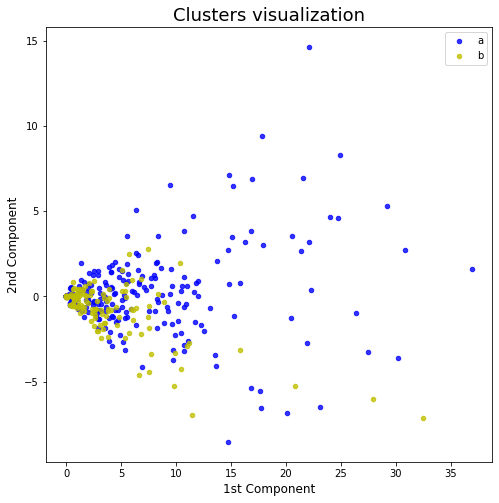

In [106]:
visualizeClusters(Bow_components, y_train, Bow_center)

In [107]:
km_bow_eval = Evaluate(y_train, y_km_bow)
km_bow_eval

,values
kappa,-0.003134
silhouette,-0.440115


In [108]:
print('Accuracy score on the traning set:')
model_MLP_bow, y_MLP_bow = MLP(X_bow_test , y_test)


Accuracy score on the traning set:
0.8671875


In [109]:
print('Accuracy score on the traning set:')
model_NB_bow, y_NB_bow = NB(X_bow_test.toarray() , y_test)

Accuracy score on the traning set:
0.8515625


In [110]:
model_SVM_bow, y_SVM_bow = SVM(X_bow_test.toarray() , y_test)
model_SVM_bow

0.9609375


SVC(gamma='auto', kernel='linear')

In [111]:
model_AGG_bow, y_agg_bow = Agglomorative(X_bow)
model_AGG_bow

AgglomerativeClustering(compute_distances=True, n_clusters=5)

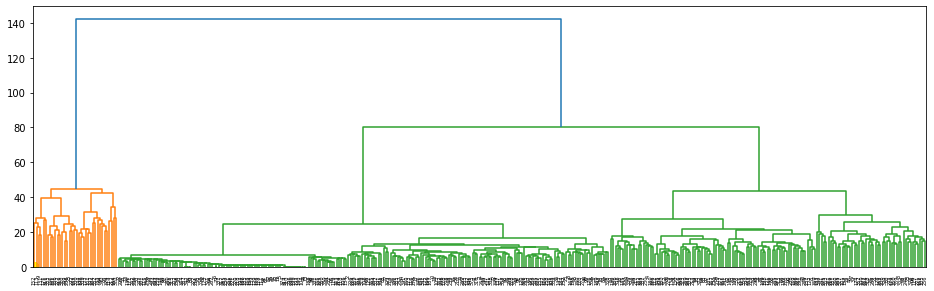

In [112]:
visualizeHierarchy(X_bow, y_agg_bow)

In [113]:
agg_bow_eval = Evaluate(y_train, y_agg_bow)
agg_bow_eval

,values
kappa,-0.004631
silhouette,-0.496253


In [114]:
def doc_relation_rate(lda_top , num):
    print("topic ",num,": ")
    for i,topic in enumerate(lda_top[num]):
        print("speaker ",i+1,": ",topic*100,"%")

In [115]:
def topic_Modeling():
    vocab = vectorizer.get_feature_names()

    for i, comp in enumerate(lda_model.components_):
        vocab_comp = zip(vocab, comp)
        sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:20]
        print("Author "+str(i+1)+": ")
        for t in sorted_words:
            print(t[0],end=" ")
        print("\n")

In [116]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

train_vectorized = vectorizer.fit_transform(X_train['text'])

In [117]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation( 
                                      n_components=2, max_iter=10, learning_method='online',   
                                      random_state=100, batch_size=128,            
                                      evaluate_every = -1, n_jobs = -1,)
lda_output = lda_model.fit_transform(train_vectorized)

print(lda_model) 

LatentDirichletAllocation(learning_method='online', n_components=2, n_jobs=-1,
                          random_state=100)


In [118]:
doc_relation_rate(lda_output,1)

topic  1 : 
speaker  1 :  92.36115976764955 %
speaker  2 :  7.638840232350437 %


In [119]:
topic_Modeling()

Author 1: 
language like product time just wallet lisp let cut account human school chain ruby transaction fog difficult step course layer 

Author 2: 
like know people thing think just kind right really lot try want work make say company way good basely world 



In [120]:
from sklearn.model_selection import GridSearchCV
search_params = {'n_components': [2], 'learning_decay': [.5, .7, .9]}
model = GridSearchCV(lda_model, param_grid=search_params)
model.fit(train_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 n_components=2, n_jobs=-1,
                                                 random_state=100),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2]})

In [121]:
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=2, n_jobs=1,perp_tol=0.1,
             random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0), n_jobs=1,
       param_grid={'n_topics': [4], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_components=2, n_jobs=1),
             n_jobs=1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9], 'n_topics': [4]},
             return_train_score='warn')

In [122]:
best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)

print("Best Log Likelihood Score: ", model.best_score_)

print("Model Perplexity: ", best_lda_model.perplexity(train_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -15114.354103758935
Model Perplexity:  1228.914438471622


In [123]:
lda_output = best_lda_model.transform(train_vectorized)
topicnames = ["speaker" + str(i+1) for i in range(best_lda_model.n_components)]
docnames = ["topic" + str(i+1) for i in range(len(X_train['text']))]
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_speaker'] = dominant_topic


def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,speaker1,speaker2,dominant_speaker
topic1,0.920000,0.080000,0
topic2,0.880000,0.120000,0
topic3,0.040000,0.960000,1
topic4,0.010000,0.990000,1
topic5,0.020000,0.980000,1
topic6,0.740000,0.260000,0
topic7,0.500000,0.500000,0
topic8,0.010000,0.990000,1
topic9,0.040000,0.960000,1
topic10,0.010000,0.990000,1


In [124]:
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
df_topic_keywords.head()

,aah,aamail,aand,aat,abio,able,aboy,abroad,absence,abuse,...,yur,yway,yyou,zak,zakeburg,zee,zocker,zok,zon,zuc
speaker1,0.569776,0.582977,0.595239,0.587021,0.577128,0.584006,0.572688,0.588297,0.589632,0.577122,...,0.608935,0.581598,0.584148,0.557139,0.596839,0.588583,0.580201,0.575382,0.552893,0.579250
speaker2,1.397530,1.465173,1.398199,1.455854,1.477139,2.317548,1.378573,1.442182,1.456151,1.465210,...,1.473696,1.361032,1.428772,2.269392,1.394092,1.437988,1.382156,1.440176,2.341480,1.463153


In [125]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['speaker '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
speaker 0,like,time,fog,cut,let,moment,just,step,programmer,word,wallet,failure,thanks,risk,advice
speaker 1,like,know,people,thing,think,just,kind,right,really,lot,try,want,work,make,say


In [126]:
lda_output.shape, train_vectorized.shape

((381, 2), (381, 2864))

In [127]:
from sklearn.cluster import KMeans
model_km_lda = KMeans(n_clusters=2)
model_km_lda.fit(train_vectorized)
y_km_lda = model_km_bow.fit_predict(train_vectorized)

In [128]:
svm = SVC(gamma='auto' , kernel = 'linear')
model_SVM = svm.fit(train_vectorized, y_train)
y_SVM = model_SVM.predict(train_vectorized)
print(accuracy_score(y_train, y_SVM))

0.968503937007874


In [129]:
from sklearn.decomposition import TruncatedSVD
from copy import deepcopy
lda_SVD = TruncatedSVD(n_components=2, random_state=42)
lda_Components = lda_SVD.fit_transform(train_vectorized)
lda_centers = lda_SVD.transform(model_km_lda.cluster_centers_)

centers_lda = deepcopy(lda_Components)

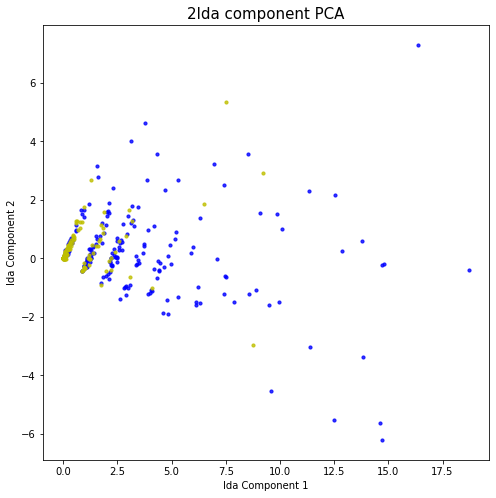

In [130]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('lda Component 1', fontsize = 10)
ax.set_ylabel('lda Component 2', fontsize = 10)
ax.set_title('2lda component PCA', fontsize = 15)

colors = ['b', 'y','r', 'g', 'c']  
for color, i, target_name in zip(colors, [0, 1, 2, 3, 4],['a', 'b', 'c', 'd','e']):
    ax.scatter(lda_Components[y_train.iloc[:,0] == i, 0], lda_Components[y_train.iloc[:,0] == i, 1],
               alpha=.8, color=color, label=target_name, s = 10)

In [131]:
km_lda_eval = Evaluate(y_train, y_km_lda)
km_lda_eval

,values
kappa,-0.016865
silhouette,-0.540443


In [132]:
model_lda_agg, pred_lda_agg = Agglomorative(lda_output)

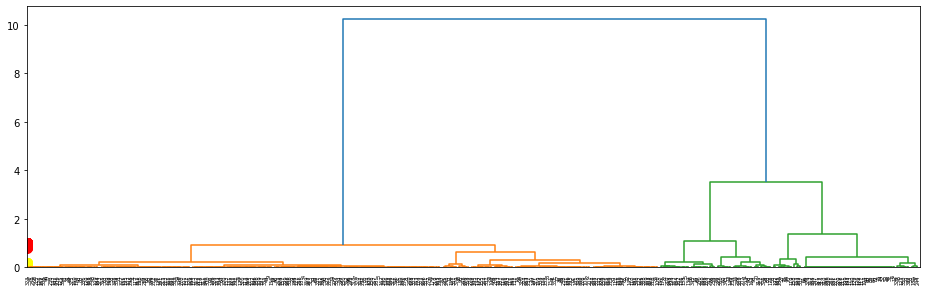

In [133]:
visualizeHierarchy(lda_output, pred_lda_agg)

In [134]:
agg_lda_eval = Evaluate(y_train, pred_lda_agg)
agg_lda_eval

,values
kappa,0.097144
silhouette,-0.190514


In [135]:
def towords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

In [136]:
data_words = list(towords(df['text']))

In [137]:
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]#TF

In [138]:
def LDA_Model(corpus,id2word):
    num_topics = 5
    # Build LDA model
    lda = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=2,random_state=12345,chunksize=100,per_word_topics=True)
    pprint(lda.print_topics())
    doc_lda = lda[corpus]
    return lda

In [139]:
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(LDA_Model(corpus,id2word), corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0,
  '0.035*"and" + 0.035*"you" + 0.034*"be" + 0.031*"like" + 0.027*"the" + '
  '0.025*"to" + 0.024*"it" + 0.020*"so" + 0.019*"that" + 0.017*"of"'),
 (1,
  '0.029*"the" + 0.028*"you" + 0.024*"like" + 0.023*"of" + 0.021*"be" + '
  '0.021*"and" + 0.019*"it" + 0.019*"that" + 0.017*"to" + 0.012*"in"')]


PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
0      0.02508  0.0       1        1  60.234324
1     -0.02508  0.0       2        1  39.765676, topic_info=           Term        Freq       Total Category  logprob  loglift
22           of  544.000000  544.000000  Default  30.0000  30.0000
28          the  777.000000  777.000000  Default  29.0000  29.0000
20      million   29.000000   29.000000  Default  28.0000  28.0000
3776     qrenby   20.000000   20.000000  Default  27.0000  27.0000
3777  valuation   20.000000   20.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
74         this   59.802902  194.663580   Topic2  -5.2330  -0.2581
186         get   60.979556  212.924752   Topic2  -5.2136  -0.3282
195        just   59.671569  230.924058   Topic2  -5.2352  -0.4311
380        they   55.295225  228.561350   Topic2  -5.3114  -0.4970
276      people   55.233589  252.539587   Topic2  -5.3125  -0.5978

[187 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1612      1  0.165416   actual
1612      2  0.827082   actual
547       1  0.805070       ah
547       2  0.185785       ah
3808      1  0.889022  alesome
...     ...       ...      ...
3821      2  0.688319      yok
172       1  0.654877      you
172       2  0.345319      you
695       1  0.765097     your
695       2  0.237700     your

[257 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])